## Analysis of feature behaviour with `XGBRegressor`

- **Data**:
    - All the events including both pions and muons
- **Model type**: 
    - Regressor 
- **Engineered features**
    - `total_in_time_hits`: total number of in-time hits in each event 
    - `x_aligned_min`: minimum hit position realigned by subtracting track position x in each event
    - `x_aligned_max`: maximum hit position realigned by subtracting track position x in each event
    - `y_aligned_min`: minimum hit position realigned by subtracting track position y in each event
    - `y_aligned_max`: maximum hit position realigned by subtracting track position y in each event
    - `x_aligned_width`: maximum hit position x minus minimum hit position x in each event
    - `y_aligned_witdh`: maximum hit position y minus minimum hit position y in each event `
    - `hit_distance_min`: minimum distance between hit position and track position in each event 
    - `hit_distance_max`: maximum distance between hit position and track position in each event 
    - `hit_distance_mean`: mean distance between hit position and track position in each event 
    - `hit_distance_median`: median distance between hit position and track position in each event
    - `hit_distance_q25`: 25% percentile distance between hit position and track position in each event
    - `hit_distance_q75`: 75% percentile distance between hit position and track position in each event
    - `hit_distance_rms`: root mean squared distance between hit position and track position in each event 
    - `hull_area`: hull area of the convex hull
    - `hull_diameter`: the longest line among all the points
    - `hull_diff_width_diameter`: the absolute difference between `hull_diameter` and `hull_width`
    - `hull_width`: closest distance of the parallel lines that encloses all points

- **Preprocessing**:
    - Only the in-time hits where delta <= 0.5 are included 


    

## Imports

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import glob
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pyarrow 
from sklearn.model_selection import cross_val_score, cross_validate, RandomizedSearchCV

## 1. Residual analysis

## 1.1 Read data and train-test-split

In [2]:
# Read in parquet files and drop NAs 
df_selected = pd.read_parquet('../../data/events_with_hit_features_[cut_off_time=0.5].parquet').dropna()

# Filter for muons only for the training set
df_muons = df_selected.query('`class`== "muon"')

# Train test split (muon data)
train_df, test_df_muon = train_test_split(df_muons, random_state=42)

# Append pion data to the test set 
test_df = pd.concat([test_df_muon, df_selected.query('`class`== "pion"')])

# Define X and y
X_train = train_df.iloc[:, 1:19]
y_train = train_df['ring_radius_cal']
X_test = test_df.iloc[:, 1:19]
y_test = test_df['ring_radius_cal']

## 1.2 Fit the model

In [3]:
# Define the model
xgb_reg = xgb.XGBRegressor()
# Fit the model
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## 1.3 Feature importance

In [4]:
# Rank the feature importance in descending order
pd.DataFrame({'features': xgb_reg.feature_names_in_, 'importance': xgb_reg.feature_importances_}).sort_values(by='importance', ascending=False)

,features,importance
10,hit_distance_median,0.867772
13,hit_distance_rms,0.040512
12,hit_distance_q75,0.020850
11,hit_distance_q25,0.013648
5,y_aligned_max,0.009103
2,x_aligned_max,0.008282
1,x_aligned_min,0.008224
15,hull_diameter,0.004398
8,hit_distance_max,0.003712
7,hit_distance_min,0.003470


## 1.4 Compute the residuals

In [5]:
# Predict on the test set
ypred = xgb_reg.predict(X_test)

Text(0, 0.5, 'Residuals')

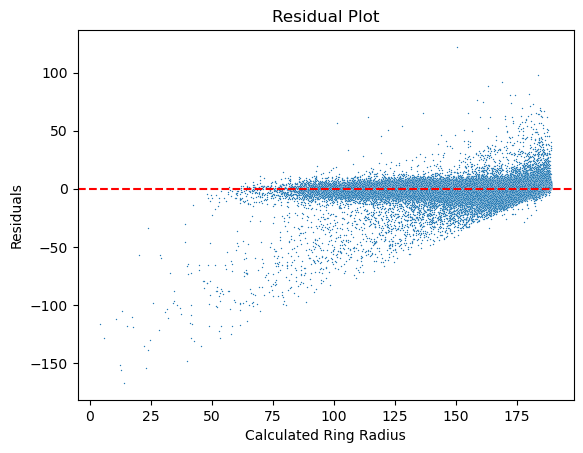

In [6]:
# Convert the prediction values to a dataframe
pred_df = pd.DataFrame(ypred, y_test).reset_index()
pred_df.columns=['theoretical_radius', 'predicted_radius']

# Calculate the residual by subtracting the predicted radius from the theoretical radius 
pred_df['residual'] = pred_df['theoretical_radius'] - pred_df['predicted_radius']

# Plot the residuals vs. the theoretical radius 
sns.scatterplot(data=pred_df, x='theoretical_radius', y='residual', s=1)

plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

## 1.5 Comparison with SOTA on the entire dataset

In [7]:
# Make a dataframe for the radii
res_comp = df_selected[['ring_radius_cal', 'ring_radius']]

In [8]:
# Predict on the entire dataset
res_comp['radius_pred'] = xgb_reg.predict(df_selected.iloc[:, 1:19])

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_23747/2759841683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_comp['radius_pred'] = xgb_reg.predict(df_selected.iloc[:, 1:19])


In [9]:
# Compute the residuals for xgb and sota
res_comp['res_model'] = res_comp['ring_radius_cal'] - res_comp['radius_pred']
res_comp['res_sota'] = res_comp['ring_radius_cal'] - res_comp['ring_radius']

/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_23747/1368632347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_comp['res_model'] = res_comp['ring_radius_cal'] - res_comp['radius_pred']
/var/folders/v0/slk4rwcj0cz5hchw7hz83hlw0000gn/T/ipykernel_23747/1368632347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_comp['res_sota'] = res_comp['ring_radius_cal'] - res_comp['ring_radius']


In [10]:
# Include track momentum and class in the dataframe
res_comp = res_comp.reset_index()
res_comp[['momentum', 'class']] = df_selected.reset_index()[['track_momentum', 'class']]

[(95.0, 200.0)]

/Users/Jialing/opt/miniconda3/envs/calorich/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/Jialing/opt/miniconda3/envs/calorich/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


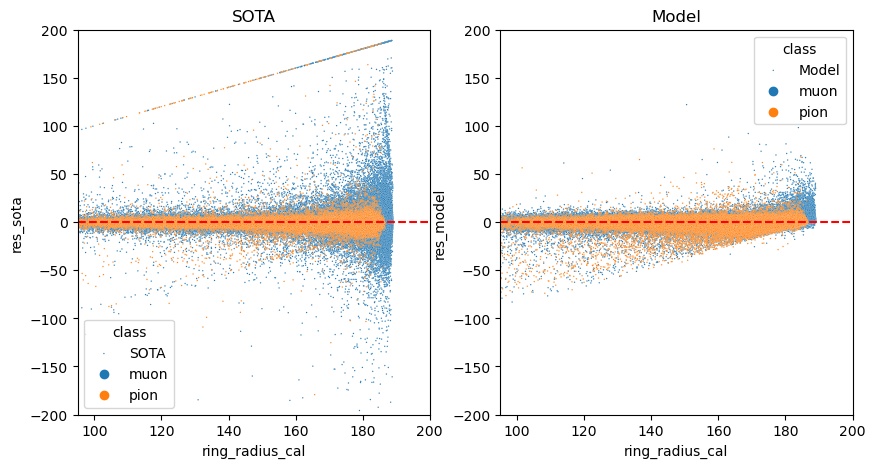

In [11]:
# Plot the residuals for sota and xgb 
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=res_comp, x='ring_radius_cal', y='res_sota', s=1, hue='class', label='SOTA', ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('SOTA')
axes[0].set(ylim = (-200, 200))
axes[0].set(xlim = (95, 200))


sns.scatterplot(data=res_comp, x='ring_radius_cal', y='res_model', s=1, hue='class', label='Model', ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('Model')
axes[1].set(ylim = (-200, 200))
axes[1].set(xlim = (95, 200))

## 1.6 Plot showing residual and `max_cal_diff` 
- `max_cal_diff` is calculated by subracting the maximum value of `ring_radius_cal` from `ring_radius_cal`
- The difference between calculated ring radius of each example and the maximum value is calculated, shown as the red line
- Points above this line indicate that the predicted radius is smaller than the max calculated ring radius


In [12]:
# Calculate max_calc_diff
res_comp['max_calc_diff'] = res_comp['ring_radius_cal'] - res_comp['ring_radius_cal'].max()

Text(0, 0.5, 'Residuals')

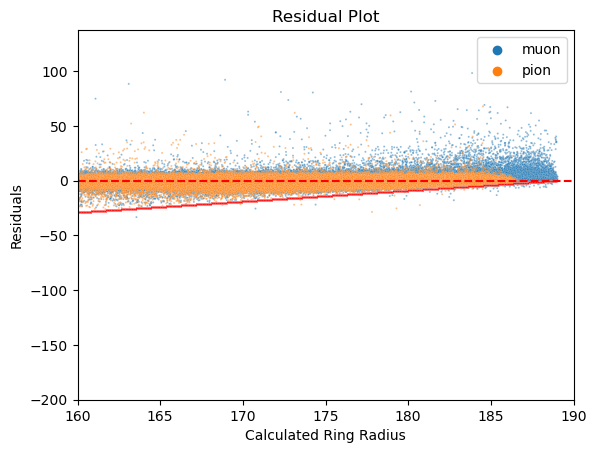

In [13]:
# Overlay the max_calc_diff on top of the reisual plot
sns.scatterplot(data=res_comp, x='ring_radius_cal', y='res_model', s=2, alpha = 0.5, hue='class')
g = sns.scatterplot(data=res_comp, x='ring_radius_cal', y='max_calc_diff', s=1, color='red', alpha=0.2)
plt.axhline(y=0, color='red', linestyle='--')
g.set_xlim(160, 190)
plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

In [14]:
# Count the number of data points below the max_calc_diff red line
res_comp.query('max_calc_diff > res_model')['class'].value_counts()

class
muon    186
pion     39
Name: count, dtype: int64

## 2. SHAP analysis 

- SHAP (SHapley Additive exPlanations) analysis is used to explain the predictions of machine learning models
- It provides a way to understand the contribution of each feature to the model's output.
- SHAP values represent the marginal contribution of a feature to the expected prediction compared to a baseline prediction.


In [15]:
import shap

/Users/Jialing/opt/miniconda3/envs/calorich/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/Jialing/opt/miniconda3/envs/calorich/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/Jialing/opt/miniconda3/envs/calorich/lib/python3.

In [16]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### SHAP explainer for the training set

In [17]:
# Define the shap explainer for the training set 
xgb_explainer = shap.TreeExplainer(xgb_reg)
train_xgb_shap_values = xgb_explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### SHAP explainer for the test set

In [18]:
# Define the shap expainer for the test set
test_xgb_shap_values = xgb_explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [19]:
# Extract feature names 
feature_names = X_train.columns

## 2.1 Show the SHAP values using a random example (4785)

- A random example is selected for SHAP analysis 

In [20]:
# Show SHAP values for example 4785 
pd.DataFrame(
    test_xgb_shap_values[4785, :],
    index=feature_names,
    columns=["SHAP values"],
)

,SHAP values
total_in_time_hits,0.074197
x_aligned_min,-0.057170
x_aligned_max,-0.026462
x_aligned_width,0.356758
y_aligned_min,0.024878
y_aligned_max,-0.097974
y_aligned_width,0.025492
hit_distance_min,-0.450617
hit_distance_max,-0.023487
hit_distance_mean,-0.066747


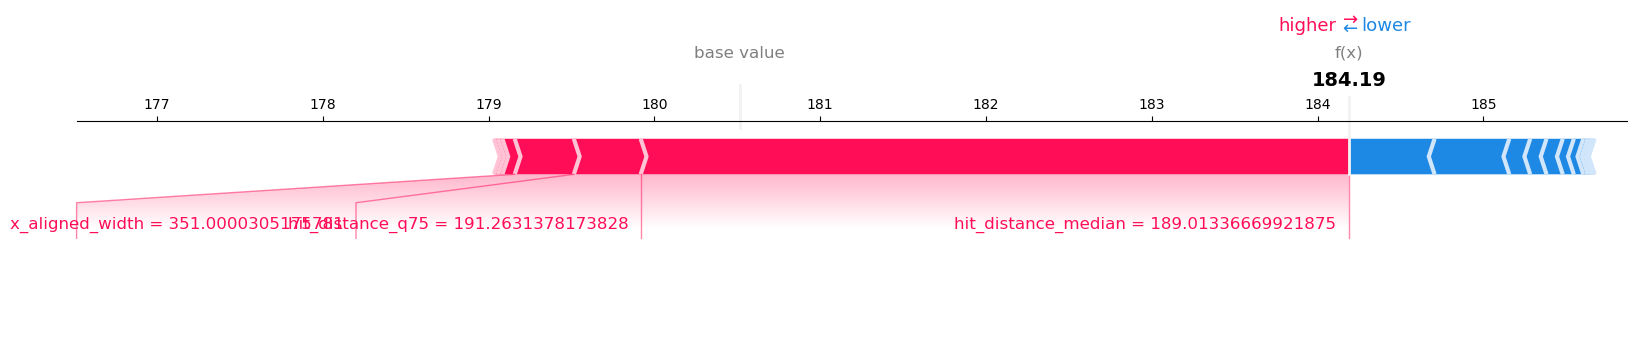

In [21]:
# Show the shap force plot 
shap.force_plot(
    xgb_explainer.expected_value,
    test_xgb_shap_values[4785, :], # SHAP values associated with the example we want to explain
    X_test.iloc[4785, :], # Feature vector of the example 
    matplotlib=True,
)

## 2.2 Global SHAP analysis
- The SHAP analysis is done on the entire dataset

In [22]:
# Show SHAP values for all the features on the entire dataset
values = np.abs(train_xgb_shap_values).mean(0) 
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)

,SHAP
hit_distance_median,5.456018
hit_distance_q25,0.781787
hit_distance_q75,0.536898
y_aligned_max,0.479577
hull_diameter,0.263208
x_aligned_max,0.191510
hit_distance_mean,0.149050
hull_area,0.144011
x_aligned_min,0.133275
total_in_time_hits,0.129795


### 2.3.1 SHAP summary plot on train set

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


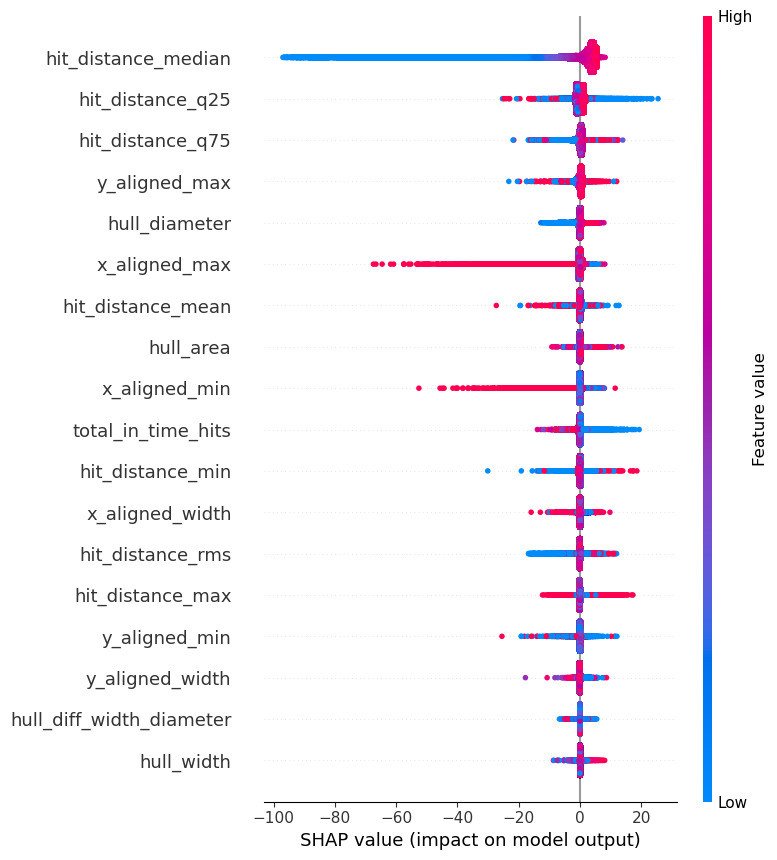

In [23]:
# Display SHAP summary plot on the train set
shap.summary_plot(train_xgb_shap_values, X_train)

### 2.3.2 SHAP summary plot on test set

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


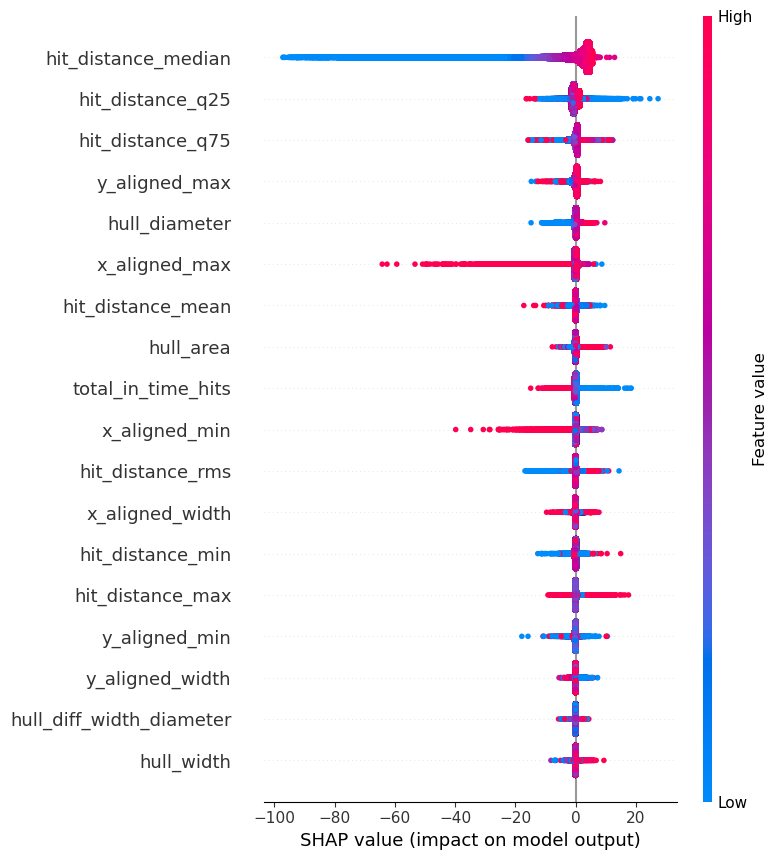

In [24]:
# Display SHAP summary plot on the test set
shap.summary_plot(test_xgb_shap_values, X_test)

- Features are ranked based on their importance, from top to bottom

- The bar on the right-hand-side indicates feature values (e.g., value of hit_distance_median)

- The x-axis indicates SHAP value:
    - A negative SHAP value indicates the feature contributes negatively to the prediction
    - A positive SHAP value indicates the feature contributes positively to the prediction


## 3. Plot predicted and theoretical radius vs. track momentum

- Green lines: theoretical ring radius vs. track momentum 
- Blue points: predicted ring radius vs. track momentum for muons
- Orange points: predicted ring radius vs. track momentum for pions
- Can see that the model underestimates radius for muons for momentum > 57 GeV/c


### 3.1 XGBRegressor model

(165.0, 195.0)

Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


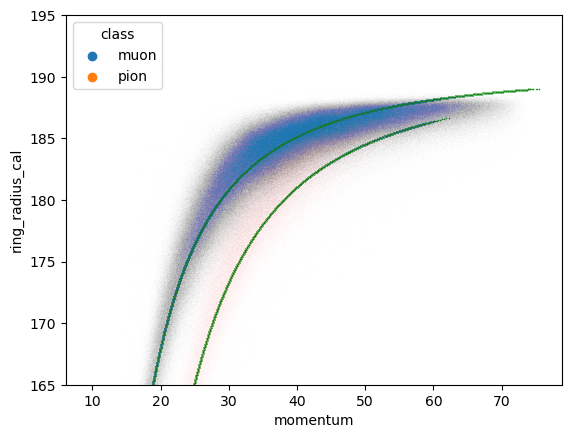

In [25]:
# Show ring radius vs. track momentum for the xgb model
sns.scatterplot(data=res_comp, x='momentum', y='ring_radius_cal', color ='green', s=1)
g = sns.scatterplot(data=res_comp, x='momentum', y='radius_pred', s=1, hue='class', alpha=0.005)

g.set_ylim(165, 195)


### 3.2 SOTA 

(165.0, 195.0)

Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


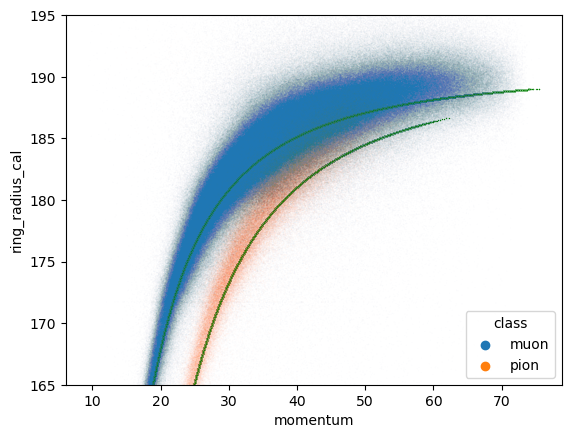

In [26]:
# Show ring radius vs. track momentum for the SOTA
sns.scatterplot(data=res_comp, x='momentum', y='ring_radius_cal', color='green', s=1)
h = sns.scatterplot(data=res_comp, x='momentum', y='ring_radius', s=1, hue='class', alpha=0.01)
h.set_ylim(165, 195)

## 4. Plot predicted radius vs. calculated ring radius

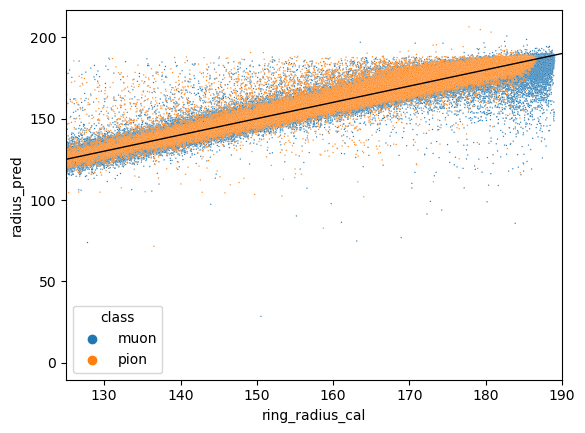

In [27]:
# Plot predicted radius vs. calculated radius 
g = sns.scatterplot(data = res_comp, x = 'ring_radius_cal', y = 'radius_pred', hue='class', s=1)
g.set_xlim(125, 190)

plt.plot([0, 190], [0, 190], color='black', linestyle='-', linewidth=1)

(170.0, 190.0)

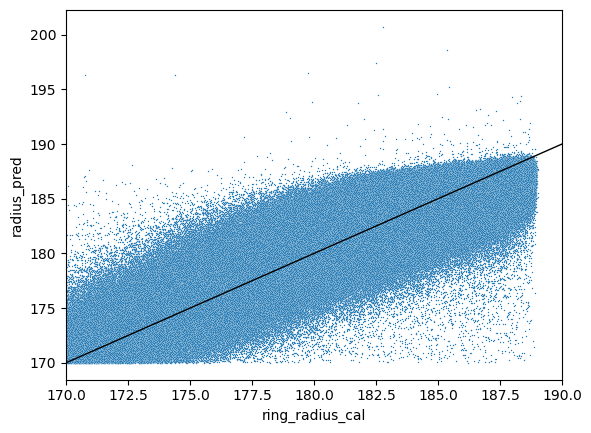

In [28]:
# A more zoomed in look for muons only 
g = sns.scatterplot(data = res_comp.query('radius_pred >=170 & `class`=="muon"'), x = 'ring_radius_cal', y = 'radius_pred', s=1)
plt.plot([170, 190], [170, 190], color='black', linestyle='-', linewidth=1)
g.set_xlim(170, 190)

In [29]:
# Cut the data into momentum bins 
bins = range(100, 191, 5)
labels = [f'{i}-{i+10}' for i in range(100, 186, 5)]
df_selected['radius_bin'] = pd.cut(df_selected['ring_radius_cal'], bins=bins, labels=labels)

## 5. Plot `hit_distance_median` vs. calculated ring radius

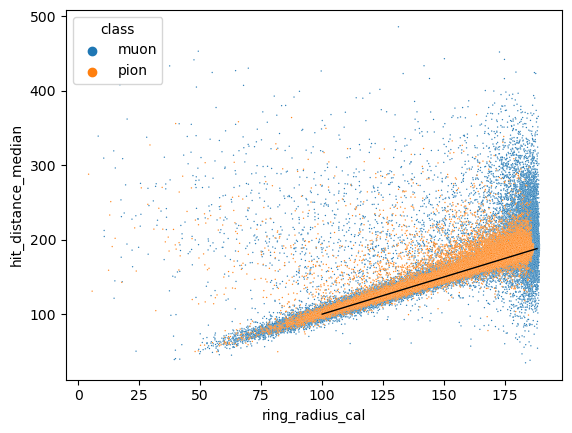

In [30]:
# Plot hit_distance_median vs. calculated ring radius
sns.scatterplot(data = df_selected, x = 'ring_radius_cal', y = 'hit_distance_median', hue='class', s=1)

plt.plot([100, 188], [100, 188], color='black', linestyle='-', linewidth=1)

## 6. Test model with `hit_distance_median` as the only feature

### 6.1 Train the model

In [31]:
# Subset the data
X_train_selected = X_train.drop(columns=['hit_distance_median'])
X_test_selected = X_test.drop(columns=['hit_distance_median'])

In [32]:
# Fit the model on the subset data
xgb_reg.fit(X_train_selected, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### 6.2 Feature importance

In [33]:
# Rank feature importance in descending order
pd.DataFrame({'features': xgb_reg.feature_names_in_, 'importance': xgb_reg.feature_importances_}).sort_values(by='importance', ascending=False)

,features,importance
11,hit_distance_q75,0.513396
12,hit_distance_rms,0.320530
10,hit_distance_q25,0.086373
9,hit_distance_mean,0.017645
5,y_aligned_max,0.016722
2,x_aligned_max,0.009625
1,x_aligned_min,0.005940
8,hit_distance_max,0.004648
7,hit_distance_min,0.004475
14,hull_diameter,0.004434


### 6.3 Compute the residuals 

In [34]:
# Predict on the test set 
y_pred_selected = xgb_reg.predict(X_test_selected)

# Compute the residuals
pred_selected_df = pd.DataFrame(y_pred_selected, y_test).reset_index()
pred_selected_df.columns=['theoretical_radius', 'predicted_radius']
pred_selected_df['residual'] = pred_selected_df['theoretical_radius'] - pred_selected_df['predicted_radius']

Text(0, 0.5, 'Residuals')

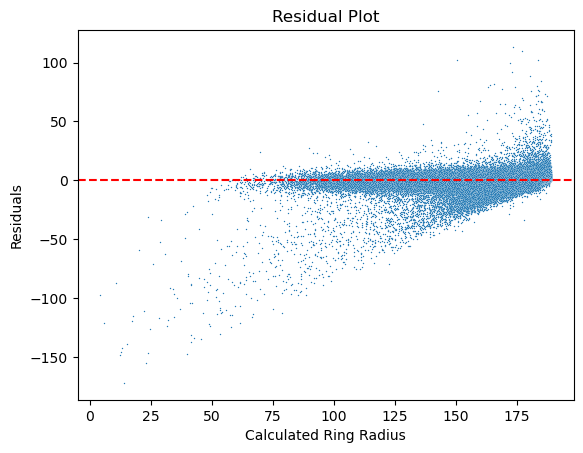

In [35]:
# Plot the residual plot
sns.scatterplot(data=pred_selected_df, x='theoretical_radius', y='residual', s=1)
plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

### 6.4 Plot predicted and theoretical ring radius vs. track momentum

In [36]:
# Make a data frame including theoretical ring radius, sota ring radius and momentum
selected_res = df_selected[['ring_radius_cal', 'ring_radius', 'track_momentum']]

In [37]:
selected_res = selected_res.reset_index()

In [38]:
# Predict on the entire dataset 
selected_res['radius_pred'] = xgb_reg.predict(df_selected.iloc[:, 1:19].drop(columns=['hit_distance_median']))

In [39]:
# Compute the residual 
selected_res['res_pred'] = selected_res['ring_radius_cal'] - selected_res['radius_pred']

In [40]:
selected_res = selected_res.reset_index()

In [41]:
# Include class labels in the dataframe
selected_res['class'] = df_selected['class']

(165.0, 195.0)

Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


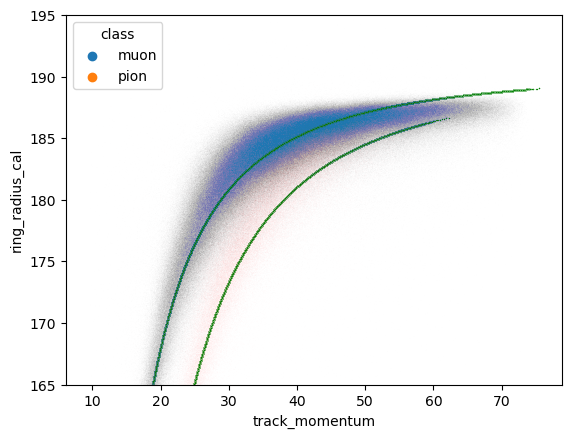

In [42]:
# Show the residual plot
sns.scatterplot(data=selected_res, x='track_momentum', y='ring_radius_cal', color ='green', s=1)
g = sns.scatterplot(data=selected_res, x='track_momentum', y='radius_pred', s=1, hue='class', alpha=0.005)

g.set_ylim(165, 195)


### 6.5 Plot showing residual and `max_cal_diff`
- `max_cal_diff` is calculated by subtracting the maximum `ring_radius_cal` value from `ring_radius_cal` (indicated as red line)

In [43]:
# Calculate `max_cal_diff`
selected_res['max_cal_diff'] = selected_res['ring_radius_cal'] - selected_res['ring_radius_cal'].max()

In [44]:
selected_res

,level_0,index,ring_radius_cal,ring_radius,track_momentum,radius_pred,res_pred,class,max_cal_diff
0,0,0,173.410156,172.410950,22.761024,170.076660,3.333496,muon,-15.624924
1,1,1,174.660522,175.251694,23.600529,176.211929,-1.551407,muon,-14.374557
2,2,2,155.299332,155.040802,16.275131,151.383347,3.915985,muon,-33.735748
3,3,3,184.035400,185.832642,36.436443,183.775665,0.259735,muon,-4.999680
4,4,4,156.473602,158.641846,16.525362,162.692291,-6.218689,muon,-32.561478
...,...,...,...,...,...,...,...,...,...
2374277,2374277,2376022,174.585281,175.371704,31.104301,175.683441,-1.098160,pion,-14.449799
2374278,2374278,2376023,176.125702,178.343094,32.657063,183.346634,-7.220932,pion,-12.909378
2374279,2374279,2376024,148.410736,148.395798,19.860395,149.113266,-0.702530,pion,-40.624344
2374280,2374280,2376025,172.438187,175.335617,29.285913,169.173737,3.264450,pion,-16.596893


Text(0, 0.5, 'Residuals')

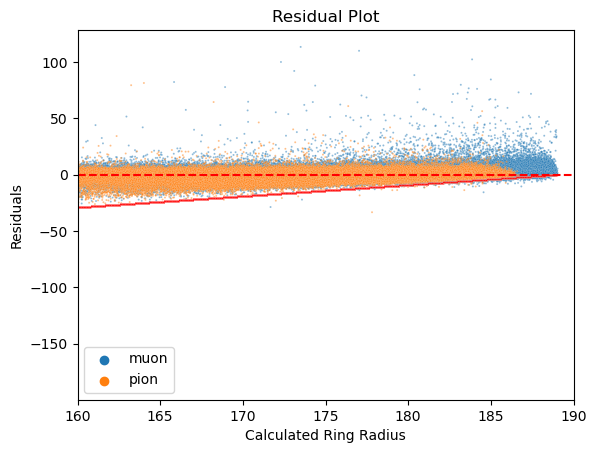

In [45]:
# Overlay `max_cal_diff` with the residual plot
sns.scatterplot(data=selected_res, x='ring_radius_cal', y='res_pred', s=2, alpha = 0.5, hue='class')
g = sns.scatterplot(data=selected_res, x='ring_radius_cal', y='max_cal_diff', s=1, color='red', alpha=0.2)
plt.axhline(y=0, color='red', linestyle='--')
g.set_xlim(160, 190)
plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

## 7. Use only `hit_distance_q75` as feature

### 7.1 Train the model

In [46]:
# Subset the data
X_train_75 = X_train['hit_distance_q75']
X_test_75 = X_test['hit_distance_q75']

In [47]:
# Fit the model
xgb_reg.fit(X_train_75, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### 7.2 Compute the residuals

In [48]:
# Predict on the test set
ypred_75 = xgb_reg.predict(X_test_75)

In [49]:
# Include the theoretical radius and predicted radius in the dataframe
pred_75_df = pd.DataFrame(ypred_75, y_test).reset_index()
pred_75_df.columns=['theoretical_radius', 'predicted_radius']

In [50]:
# Compute the residual
pred_75_df['residual'] = pred_75_df['theoretical_radius'] - pred_75_df['predicted_radius']

Text(0, 0.5, 'Residuals')

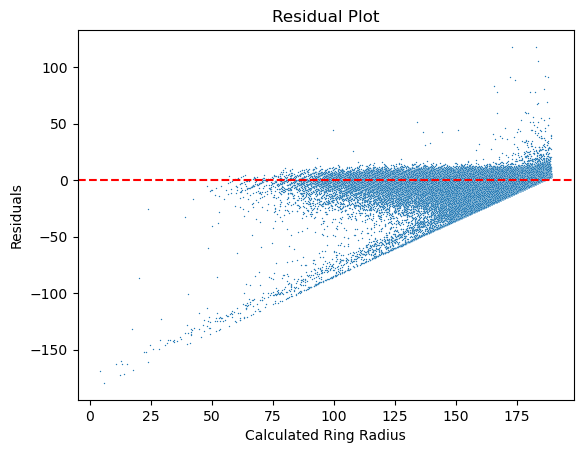

In [51]:
# Plot the residual plot
sns.scatterplot(data=pred_75_df, x='theoretical_radius', y='residual', s=1)
plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

## 8. Use only `hit_distance_mean` as feature

### 8.1 Train the model

In [52]:
# Subset the data
X_train_mean = X_train['hit_distance_mean']
X_test_mean = X_test['hit_distance_mean']

In [53]:
# Fit the model
xgb_reg.fit(X_train_mean, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### 8.2 Predict on the test set

In [54]:
# Predict on the test set
ypred_mean = xgb_reg.predict(X_test_mean)

In [55]:
# Compute the residuals 
pred_mean_df = pd.DataFrame(ypred_mean, y_test).reset_index()
pred_mean_df.columns=['theoretical_radius', 'predicted_radius']
pred_mean_df['residual'] = pred_mean_df['theoretical_radius'] - pred_mean_df['predicted_radius']

Text(0, 0.5, 'Residuals')

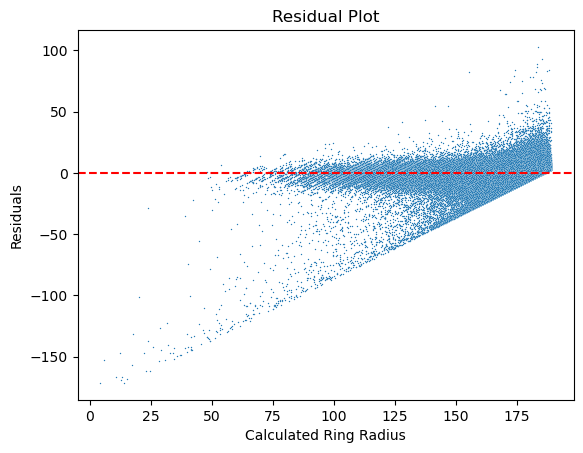

In [56]:
# Plot the residual plot 
sns.scatterplot(data=pred_mean_df, x='theoretical_radius', y='residual', s=1)
plt.axhline(y=0, color='red', linestyle='--')

plt.title('Residual Plot')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residuals')

## 9. Conclusion:

- The ring radius is underestimated for larger values 
- The most important feature, hit_distance_median, starts to underestimate the prediction for radius over 180 mm
- This effect seems to be attributed to the upper limit of max calculated radius (~ 189 mm)  
